<a href="https://colab.research.google.com/github/a-woodbury/RxVision/blob/master/Notebooks/rxv_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RxID**

RxID is a Deep Learning model for identifying medications from an image. It is trained on images from the NIH/NLM dataset, which is accessed through FTP.

This notebook is designed to allow a data scientist to select the drugs they would like to include in their model, collect sample images to confirm, download the images to their local directory, and sort by class (NDC).

# Setup

## Import Packages

In [0]:
import pandas as pd
import requests
from IPython.display import Image
from ftplib import FTP #needed to make the request to the server

# packages for processing images
! pip install rawpy
from PIL import Image
from PIL import ImageFile
import rawpy
import imageio
ImageFile.LOAD_TRUNCATED_IMAGES = True


import os, shutil, sys #required for moving files

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from pathlib import Path

In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!


# Create Dataset

## Define Classes

Two paths: select your NDCs to train by their count of images (for a balanced dataset) or by specific NDCs (classes may be imbalanced and require additional manipulation)

### By **NDC**

If you know the NDCs you would like to train your model, you may enter them into the dloadndcs list 

In [0]:
ndcs = [    
'00009033102',    
'65862019430',
'00591084510',
'55111068305',
'00527134410',
'00093005801',    
'45802091987',
'61958070101',
'49884003501',
'00591078005',
'31722020701',
'68180047901',
'65862007701',
'00054472825',
'68180040301'
]

In [0]:
len(set(ndcs))

15

In [0]:
ndcs_pack = [x[:-2] for x in ndcs]

In [0]:
%cd ../..

/home/jupyter/RxID2


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%pwd

'/home/jupyter/RxID2'

In [0]:
%cd Notebooks
typdict = {'NDC':'str'}
df = pd.read_csv('/content/drive/My Drive/RxID2/directory_of_images.txt',sep='|', dtype=typdict, names=['NDC','IDK','FILE','TYPE','DRUG'])
df = df.dropna()
df.DRUG = df.DRUG.str.upper()
df[['ORIG_FOLDER','IMAGES','FILENAME']] = df.FILE.str.split('/', expand=True)
df['FILETYPE'] = df.FILENAME.str[-4:]
df = df[df.FILETYPE != '.WMV']# will remove video files from query
df['NDC_prod'] = df.NDC.str[:-2]
df = df[df.NDC_prod.isin(ndcs_pack)]
df

[Errno 2] No such file or directory: 'Notebooks'
/content


,NDC,IDK,FILE,TYPE,DRUG,ORIG_FOLDER,IMAGES,FILENAME,FILETYPE,NDC_prod
2946,00009033102,1,PillProjectDisc58/images/CB4CEJKI72-2IAAF8SPNK...,C3PI_Reference,CLEOCIN 75MG CAPS,PillProjectDisc58,images,CB4CEJKI72-2IAAF8SPNK-YD6QHSBHE.CR2,.CR2,000090331
2947,00009033102,1,PillProjectDisc95/images/MJ8SIXGLA!IDK6QKOJQ8N...,C3PI_Reference,CLEOCIN 75MG CAPS,PillProjectDisc95,images,MJ8SIXGLA!IDK6QKOJQ8N5DOBZIKHE.CR2,.CR2,000090331
2949,00009033102,1,PillProjectDisc107/images/XW27OGQ!GSTCS6SVCFSE...,C3PI_Test,CLEOCIN 75MG CAPS,PillProjectDisc107,images,XW27OGQ!GSTCS6SVCFSE6F!WHA7PYT.JPG,.JPG,000090331
2950,00009033102,1,PillProjectDisc13/images/9CLLUNVVKAJ4Y!Q0R_4_H...,C3PI_Test,CLEOCIN 75MG CAPS,PillProjectDisc13,images,9CLLUNVVKAJ4Y!Q0R_4_H0I4EVZG5C.JPG,.JPG,000090331
2951,00009033102,1,PillProjectDisc17/images/B18QCJP3ZMIWFPGXJZ4R3...,C3PI_Test,CLEOCIN 75MG CAPS,PillProjectDisc17,images,B18QCJP3ZMIWFPGXJZ4R3I-OL2GR6Z-.JPG,.JPG,000090331
...,...,...,...,...,...,...,...,...,...,...
127776,68180047901,1,PillProjectDisc42/images/BP4V9ZT0LMIB4BO872E-W...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc42,images,BP4V9ZT0LMIB4BO872E-WK025340X84.PNG,.PNG,681800479
127777,68180047901,1,PillProjectDisc51/images/BXRU3YZEHJU82Z4XML43I...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc51,images,BXRU3YZEHJU82Z4XML43IK7X1JWYWH7.PNG,.PNG,681800479
127778,68180047901,1,PillProjectDisc72/images/CN_3M1A3P5IO95ONJAKUI...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc72,images,CN_3M1A3P5IO95ONJAKUIFJYQC18Y9_.PNG,.PNG,681800479
127779,68180047901,1,PillProjectDisc83/images/CY8E7A05V71HWIUH2IQOZ...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc83,images,CY8E7A05V71HWIUH2IQOZYMM-2BJSD8.PNG,.PNG,681800479


In [0]:
df.NDC.value_counts()

00527134410    55
00009033102    50
00591084510    50
65862019430    50
55111068305    50
00591078005    36
00054472825    34
00093005801    34
68180047901    34
61958070101    34
00093005805    33
31722020701    31
45802091987    30
49884003501    30
65862007701    28
68180040301    28
Name: NDC, dtype: int64

In [0]:
df.DRUG.value_counts()

LEVOTHYROXINE 0.088MG TABS            55
FLUOXETINE 40MG CAP                   50
GLIPIZIDE ER 10MG TAB                 50
IBUPROFEN 600MG TAB                   50
CLEOCIN 75MG CAPS                     50
SUCRALFATE 1 GRAM TABLETS             36
SIMVASTATIN                           34
PREDNISONE                            34
TRUVADA TAB                           34
TRAMADOL HYDROCHLORIDE TABLETS        34
TRAMADOL HYDROCHLORIDE TABLETS USP    33
CITALOPRAM TABLETS, USP               31
MECLIZINE 25MG TABS                   30
CETIRIZINE TAB 10MG                   30
CIPROFLOXACN 500MG TAB                28
CEFPROZIL 250MG TABS                  28
Name: DRUG, dtype: int64

## Review Dataset

We noticed many DRUG names have variations within an NDC, likely due to different data entry. Before proceeding, we will make all the names the same for each NDC. 

In [0]:
df.NDC[df.NDC == '00093005805'] = '00093005801'

df.DRUG[df.NDC == '00555188302'] = 'BENZONATATE'
df.DRUG[df.NDC == '00781196160'] = 'CLARITHROMYCIN 250MG'
df.DRUG[df.NDC == '00009033102'] = 'CLEOCIN 75MG'
df.DRUG[df.NDC == '65862019430'] = 'FLUOXETINE 40MG '
df.DRUG[df.NDC == '65862019905'] = 'GABAPENTIN 300MG'
df.DRUG[df.NDC == '00591084510'] = 'GLIPIZIDE ER 10MG'
df.DRUG[df.NDC == '64125013010'] = 'HCTZ 50MG'
df.DRUG[df.NDC == '00527134410'] = 'TRAMADOL TAB'
df.DRUG[df.NDC == '24486060490'] = 'HYOMAX-DT 0.375MG'
df.DRUG[df.NDC == '24486060310'] = 'HYOMAX-FT 0.125MG'
df.DRUG[df.NDC == '00093005801'] = 'LEVOTHYROXINE 0.088MG'
df.DRUG[df.NDC == '55111068305'] = 'IBUPROFEN 600MG'
df.DRUG[df.NDC == '24090047988'] = 'INDERAL LA 160MG'
df.DRUG[df.NDC == '00093402901'] = 'INDOMETHACIN'
df.DRUG[df.NDC == '00093576756'] = 'OLANZAPINE 2.5MG'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: Se

In [0]:
df

,NDC,IDK,FILE,TYPE,DRUG,ORIG_FOLDER,IMAGES,FILENAME,FILETYPE,NDC_prod
2946,00009033102,1,PillProjectDisc58/images/CB4CEJKI72-2IAAF8SPNK...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc58,images,CB4CEJKI72-2IAAF8SPNK-YD6QHSBHE.CR2,.CR2,000090331
2947,00009033102,1,PillProjectDisc95/images/MJ8SIXGLA!IDK6QKOJQ8N...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc95,images,MJ8SIXGLA!IDK6QKOJQ8N5DOBZIKHE.CR2,.CR2,000090331
2949,00009033102,1,PillProjectDisc107/images/XW27OGQ!GSTCS6SVCFSE...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc107,images,XW27OGQ!GSTCS6SVCFSE6F!WHA7PYT.JPG,.JPG,000090331
2950,00009033102,1,PillProjectDisc13/images/9CLLUNVVKAJ4Y!Q0R_4_H...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc13,images,9CLLUNVVKAJ4Y!Q0R_4_H0I4EVZG5C.JPG,.JPG,000090331
2951,00009033102,1,PillProjectDisc17/images/B18QCJP3ZMIWFPGXJZ4R3...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc17,images,B18QCJP3ZMIWFPGXJZ4R3I-OL2GR6Z-.JPG,.JPG,000090331
...,...,...,...,...,...,...,...,...,...,...
127776,68180047901,1,PillProjectDisc42/images/BP4V9ZT0LMIB4BO872E-W...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc42,images,BP4V9ZT0LMIB4BO872E-WK025340X84.PNG,.PNG,681800479
127777,68180047901,1,PillProjectDisc51/images/BXRU3YZEHJU82Z4XML43I...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc51,images,BXRU3YZEHJU82Z4XML43IK7X1JWYWH7.PNG,.PNG,681800479
127778,68180047901,1,PillProjectDisc72/images/CN_3M1A3P5IO95ONJAKUI...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc72,images,CN_3M1A3P5IO95ONJAKUIFJYQC18Y9_.PNG,.PNG,681800479
127779,68180047901,1,PillProjectDisc83/images/CY8E7A05V71HWIUH2IQOZ...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc83,images,CY8E7A05V71HWIUH2IQOZYMM-2BJSD8.PNG,.PNG,681800479


In [0]:
df.DRUG.value_counts()

LEVOTHYROXINE 0.088MG        67
TRAMADOL TAB                 55
IBUPROFEN 600MG              50
GLIPIZIDE ER 10MG            50
CLEOCIN 75MG                 50
FLUOXETINE 40MG              50
SUCRALFATE 1 GRAM TABLETS    36
SIMVASTATIN                  34
PREDNISONE                   34
TRUVADA TAB                  34
CITALOPRAM TABLETS, USP      31
MECLIZINE 25MG TABS          30
CETIRIZINE TAB 10MG          30
CIPROFLOXACN 500MG TAB       28
CEFPROZIL 250MG TABS         28
Name: DRUG, dtype: int64

In [0]:
#this dataframe will display just the DRUG-NDC pairs for the model to be trained
df_a = df.groupby(['DRUG','NDC']).count()
df_a.reset_index(inplace=True)
drug_ndc = df_a[['DRUG','NDC']]
drug_ndc

,DRUG,NDC
0,CEFPROZIL 250MG TABS,68180040301
1,CETIRIZINE TAB 10MG,45802091987
2,CIPROFLOXACN 500MG TAB,65862007701
3,"CITALOPRAM TABLETS, USP",31722020701
4,CLEOCIN 75MG,00009033102
5,FLUOXETINE 40MG,65862019430
6,GLIPIZIDE ER 10MG,00591084510
7,IBUPROFEN 600MG,55111068305
8,LEVOTHYROXINE 0.088MG,00093005801
9,MECLIZINE 25MG TABS,49884003501


## Get Sample Images

It may be prudent to confirm the selected NDCs will produce a useful and varied dataset for image classification training. These cells will request 1 image for each NDC and showcase the medication.

In [0]:
dfx = df[df.TYPE == 'MC_COOKED_CALIBRATED_V1.2']
dfx.NDC.value_counts().index.to_list()

['00093005801',
 '61958070101',
 '00009033102',
 '31722020701',
 '65862019430',
 '00054472825',
 '00591078005',
 '00591084510',
 '68180040301',
 '45802091987',
 '68180047901',
 '55111068305',
 '49884003501',
 '65862007701',
 '00527134410']

In [0]:
#define the images to request from the server; one file for each NDC in df will be selected
samplesdf = dfx.groupby(['NDC']).min().reset_index()
samplesdf.sort_values('NDC')

sampleslist = samplesdf.FILE.tolist()
sampleslist.sort()

In [0]:
# for each image in the sampleslist, we will create a key-value pair in a dictionary of the filename and its folder in the ftp directory
ftpdir = {}
for i in range(0,len(sampleslist)):
    ftpcall = sampleslist[i].split('/')
    ftppath = ftpcall[0]+'/'+ftpcall[1]+ '/'
    ftpfile = ftpcall[-1]
    ftpdir.setdefault(ftppath,[])
    ftpdir[ftppath].append(ftpfile)
#ftpdir

In [0]:
%pwd

'/content'

In [0]:
%cd /content/drive/My Drive/RxID2/Data

/content/drive/My Drive/RxID2/Data


In [0]:
#the ftp call is made; ftplib will use the dictionary to iterate throught the folders housing the files needed to sample. 

try:
    os.makedirs('Download')
except:
    print('Folders present')

In [0]:
%cd Download

/content/drive/My Drive/RxID2/Data/Download


In [0]:
dloaded = os.listdir() # get list of unprocessed images in the 'Download' folder
for key in ftpdir.keys():
    ftp = FTP('lhcftp.nlm.nih.gov')
    ftp.login()
    ftp.cwd('Open-Access-Datasets/Pills//')
    ftp.cwd(key)
    for value in ftpdir[key]:
        if value not in dloaded: # If your download is interrupted, this code block will check if you've already downloaded a file and skip it, saving some time
            with open(value, 'wb') as fp:
                ftp.retrbinary('RETR '+ value, fp.write)
    ftp.cwd('..')
    ftp.cwd('..')

#converting images to a smaller format JPG
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".JPG"): 
        im1 = Image.open(r'{}'.format(filename))
        rgb_im = im1.convert('RGB')
        rgb_im.save(r'{}.JPG'.format(filename[:-4]))
        continue
    elif filename.endswith(".CR2") and os.path.getsize(filename) > 0: # CR2 is a Canon professional image format; some files were corrupted and we will skip them
        raw = rawpy.imread('{}'.format(filename))
        rgb = raw.postprocess()
        imageio.imsave('{}.JPG'.format(filename[:-4]), rgb)
        continue
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".CR2"):
        os.remove(filename)
    elif os.path.isdir(filename):
        shutil.rmtree(filename)
    elif filename.startswith('.'):
        os.remove(filename)

In [0]:
%cd ../Data/Download

[Errno 2] No such file or directory: '../Data/Download'
/content/drive/My Drive/RxID2/Data/Download


In [0]:
sampleslist2 = samplesdf.FILE.tolist()

In [0]:
samplefiles = []
for image in sampleslist2:
    smplsplt = image.split('/')
    keep = smplsplt[-1]
    keep = keep[:-4]
    keep= keep +('.JPG')
    samplefiles.append(keep)

#for file in os.listdir():
drgimg = os.listdir()
images = []
for file in samplefiles:
    data = plt.imread(file)
    images.append(data)

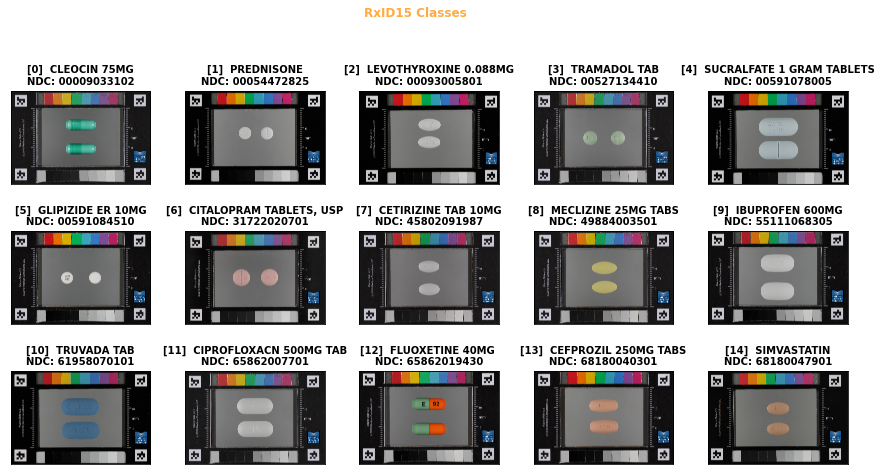

In [0]:
plt.figure(figsize=(15,11))
columns = 5
for i, image in enumerate(images): # iterate through the images in the array 'images'
    dname = df.DRUG[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the drug name from the df for the image in index i 
    dndc = df.NDC[df.FILENAME.str.contains(samplefiles[i][:-4])].tolist()[0] # get the NDC from the df for the image in index i 
    title = '[' + str(i) + '] ' + ' ' + dname + '\nNDC: ' + str(dndc) # title for each subplot: class, drug name, and NDC
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.suptitle('RxID15 Classes',fontweight='bold',fontsize='large', color= '#ffab40')
    plt.subplots_adjust(hspace=0.05,wspace=0.25, top=.9, bottom=.2) # i believe this is the subplots spacing from each other and within the plot
    plt.margins(tight=True) # not sure which margins this is impacting
    plt.title(title,fontweight='semibold',fontsize='10')
    plt.imshow(image)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    #plt.savefig('../../Images/classes3.jpg',format='jpg',quality=95,dpi=300, bbox='tight',pad_inches = 0) # bbox has always given me the output i wanted...

## Get Train/Test Images

These code blocks are where your dataset will be downloaded to your local directory.





In [0]:
drugsftp = df.FILE.tolist()
drugsftp.sort()
drugsftp[:10] # the list of files you are requesting from the ftp server

['PillProjectDisc1/images/!1ECEZFCQZ5I6S0RP6IZ-T!_6Y2RXW.PNG',
 'PillProjectDisc1/images/!AOKWIRBTDVYLX41JNYGUE1OPO6-15.JPG',
 'PillProjectDisc1/images/!ER_L-9UW4J0KP5FQTJ2-LQKM!FKUK.JPG',
 'PillProjectDisc1/images/!RASGCGC5SYGS!IO9BV7LGPDWRYAKC.PNG',
 'PillProjectDisc1/images/!RI!43F-63PT8X1IRKA_BXYNUQ4-IT.JPG',
 'PillProjectDisc1/images/!VNV0FNW6HS3ENSDUTBIKD-SFWCXIH.JPG',
 'PillProjectDisc1/images/!Y7FKLUPG3TK-OZ7A5EVQCVF420-VJ.PNG',
 'PillProjectDisc10/images/6JNJRHBSSKORD05NM42GEQJ9GL54JQ.JPG',
 'PillProjectDisc10/images/6U0QV!Q!2FKM31JEK-_-MFJL83CC8_.JPG',
 'PillProjectDisc10/images/6UFKARR8JAS2HO771K5QNIB0!_B019.JPG']

In [0]:
ftpdir = {}
for i in range(0,len(drugsftp)):
    ftpcall = drugsftp[i].split('/') #separate the folder from the file
    ftppath = ftpcall[0]+'/'+ftpcall[1]+ '/'
    ftpfile = ftpcall[-1] #isolate the filename
    ftpdir.setdefault(ftppath,[])
    ftpdir[ftppath].append(ftpfile) #create the folder:file pair
len(ftpdir)

110

In [0]:
dloaded = os.listdir() # get list of unprocessed images in the 'Download' folder
for key in ftpdir.keys():
    ftp = FTP('lhcftp.nlm.nih.gov')
    ftp.login()
    ftp.cwd('Open-Access-Datasets/Pills//')
    ftp.cwd(key)
    for value in ftpdir[key]:
        if value not in dloaded: # If your download is interrupted, this code block will check if you've already downloaded a file and skip it, saving some time
            with open(value, 'wb') as fp:
                ftp.retrbinary('RETR '+ value, fp.write)
    ftp.cwd('..')
    ftp.cwd('..')

#converting images to a smaller format JPG
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".JPG"): 
        im1 = Image.open(r'{}'.format(filename))
        rgb_im = im1.convert('RGB')
        rgb_im.save(r'{}.JPG'.format(filename[:-4]))
        continue
    elif filename.endswith(".CR2") and os.path.getsize(filename) > 0: # CR2 is a Canon professional image format; some files were corrupted and we will skip them
        raw = rawpy.imread('{}'.format(filename))
        rgb = raw.postprocess()
        imageio.imsave('{}.JPG'.format(filename[:-4]), rgb)
        continue
for filename in os.listdir():
    if filename.endswith(".PNG") or filename.endswith(".CR2"):
        os.remove(filename)
    elif os.path.isdir(filename):
        shutil.rmtree(filename)
    elif filename.startswith('.'):
        os.remove(filename)

## Sort Images by Class

In [0]:
df['FILENAME'] = df.FILENAME.str[:-4] + '.JPG' #all files are now .JPG in the local directory, updating df to reflect

In [0]:
%pwd

'/home/jupyter/RxID2/Data/Download'

In [0]:
%cd ..

/content/drive/My Drive/RxID2/Data


In [0]:
try:
    os.makedirs('Classes') #create a directory for this collection of drugs images 
except:
    print('Folder already created')

for img in os.listdir('Download'):
    try:
        folder = df.NDC[df.FILENAME == img].tolist()[0] # get the NDC for the drug being iterated
    except:
        print('{} not in df'.format(img)) # in case an errant file made it through, we dont want to add to our sorted directories
  
    try:
        classed = 'Classes/{}'.format(folder)
        os.mkdir(classed) # create a folder if it doesnt already exist
    except:
        print('folder_exists...')
  
    try:
        origin = os.path.join('Download', img) # find our image in unclassed...
        destination = os.path.join(classed, img) #declare where we want to put it.... 
        shutil.copy(origin, destination) # and copy the file 
    except:
        print('Could not copy file {}'.format(img))

folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists...
folder_exists.

In [0]:
# finally we print our new class directories and their file counts 
for fldr in os.listdir('Classes'):
    files = len(os.listdir('Classes'+ '/' + fldr))
    print(fldr.title() + ' : ' + str(files))

45802091987 : 30
00591078005 : 36
65862019430 : 50
00591084510 : 50
61958070101 : 34
68180040301 : 28
49884003501 : 30
00093005801 : 67
55111068305 : 50
68180047901 : 34
31722020701 : 31
00009033102 : 50
00527134410 : 55
65862007701 : 28
00054472825 : 34


In [0]:
#shutil.rmtree('download') # delete the download images if desired

In [0]:
%pwd

'/home/jupyter/RxID/Data'

In [0]:
new_dir         = 'RxID2_split'

train_folder    = os.path.join(new_dir, 'train')
test_folder     = os.path.join(new_dir, 'test')
val_folder      = os.path.join(new_dir, 'validation')

try:
    os.mkdir(new_dir)
    os.mkdir(train_folder)
    os.mkdir(test_folder)
    os.mkdir(val_folder)
except:
    print('Folders already made')

In [0]:
for item in os.listdir('Classes'):
    class_train = os.path.join(train_folder, item)
    class_test  = os.path.join(test_folder, item)
    class_val  = os.path.join(val_folder, item)
    try:
        os.mkdir(class_train)
        os.mkdir(class_test)
        os.mkdir(class_val)
    except:
        print('Folders present')
  
    classdir = 'Classes/{}'.format( item)
    imgs_class = os.listdir(classdir)

    imgs = imgs_class[:20]
    for img in imgs:
        origin = os.path.join(classdir, img)
        destination = os.path.join(class_train, img)
        try:
            shutil.copyfile(origin, destination)
        except:
            continue
  
    imgs = imgs_class[20:25]
    for img in imgs:
        origin = os.path.join(classdir, img)
        destination = os.path.join(class_val, img)
        try:
            shutil.copyfile(origin, destination)
        except:
            continue
  
    imgs = imgs_class[25:30]
    for img in imgs:
        origin = os.path.join(classdir, img)
        destination = os.path.join(class_test, img)
        try:
            shutil.copyfile(origin, destination)
        except:
            continue

In [0]:
df

,NDC,IDK,FILE,TYPE,DRUG,ORIG_FOLDER,IMAGES,FILENAME,FILETYPE,NDC_prod
2946,00009033102,1,PillProjectDisc58/images/CB4CEJKI72-2IAAF8SPNK...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc58,images,CB4CEJKI72-2IAAF8SPNK-YD6QHSBHE.JPG,.CR2,000090331
2947,00009033102,1,PillProjectDisc95/images/MJ8SIXGLA!IDK6QKOJQ8N...,C3PI_Reference,CLEOCIN 75MG,PillProjectDisc95,images,MJ8SIXGLA!IDK6QKOJQ8N5DOBZIKHE.JPG,.CR2,000090331
2949,00009033102,1,PillProjectDisc107/images/XW27OGQ!GSTCS6SVCFSE...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc107,images,XW27OGQ!GSTCS6SVCFSE6F!WHA7PYT.JPG,.JPG,000090331
2950,00009033102,1,PillProjectDisc13/images/9CLLUNVVKAJ4Y!Q0R_4_H...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc13,images,9CLLUNVVKAJ4Y!Q0R_4_H0I4EVZG5C.JPG,.JPG,000090331
2951,00009033102,1,PillProjectDisc17/images/B18QCJP3ZMIWFPGXJZ4R3...,C3PI_Test,CLEOCIN 75MG,PillProjectDisc17,images,B18QCJP3ZMIWFPGXJZ4R3I-OL2GR6Z-.JPG,.JPG,000090331
...,...,...,...,...,...,...,...,...,...,...
127776,68180047901,1,PillProjectDisc42/images/BP4V9ZT0LMIB4BO872E-W...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc42,images,BP4V9ZT0LMIB4BO872E-WK025340X84.JPG,.PNG,681800479
127777,68180047901,1,PillProjectDisc51/images/BXRU3YZEHJU82Z4XML43I...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc51,images,BXRU3YZEHJU82Z4XML43IK7X1JWYWH7.JPG,.PNG,681800479
127778,68180047901,1,PillProjectDisc72/images/CN_3M1A3P5IO95ONJAKUI...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc72,images,CN_3M1A3P5IO95ONJAKUIFJYQC18Y9_.JPG,.PNG,681800479
127779,68180047901,1,PillProjectDisc83/images/CY8E7A05V71HWIUH2IQOZ...,MC_COOKED_CALIBRATED_V1.2,SIMVASTATIN,PillProjectDisc83,images,CY8E7A05V71HWIUH2IQOZYMM-2BJSD8.JPG,.PNG,681800479


In [0]:
df.to_csv('../Data/rxid15.csv')